<a href="https://colab.research.google.com/github/bdu-birhanu/HHD-Ethiopic/blob/main/demo_Plain_CTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the Test Data  and Model
 This section demonstrates the process of downloading the test data  and model and evaluating its performance. Follow the steps below:

In [3]:
import editdistance
import tensorflow as tf
from keras import backend as K
import cv2


In [ ]:
from google.colab import drive
import requests
import zipfile
import os
# Mount your Google Drive
drive.mount('/content/drive')


### Download the Testset
Use the following code to download the test data ( data randomly selectd from the training set)from the Hugging face. Please follow the same step if your are interested withe second test dataset.  And extrct them in to a path as the dataset is in zip file.

In [5]:
import requests
import zipfile
import numpy as np

# Download the zip file from Hugging Face (when coping ht elink just replace "blob" by "resolve" so as to reference the file contents.)
url= "https://huggingface.co/datasets/OCR-Ethiopic/HHD-Ethiopic/resolve/main/test/test_rand/test_rand_numpy.zip"
response = requests.get(url)

# Save the zip file
zip_path = "/content/test_rand_numpy.zip"
with open(zip_path, "wb") as file:
    file.write(response.content)

# Extract the zip file
extract_path = "/content/test"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# Load the numpy file from the path we extracted
import numpy as np
x_test_rand= np.load('/content/test/test_rand_numpy/x_test_rand.npy',allow_pickle=True)
y_test_rand= np.load('/content/test/test_rand_numpy/y_test_rand.npy',allow_pickle=True)

In [6]:
x_test_rand.shape

(6375,)



### Image size normalization
Normalize the image to 48 by 368, keeping the aspect-ratio.

In [7]:
im_row=48
im_col=368
def resize(x_image):


    resized_x_rand = np.zeros((len(x_image), im_row, im_col), dtype=np.uint8)

    # loop over the input images
    for i, image in enumerate(x_image):
        # resize the image to 48 by 368 using padding
        current_height, current_width = image.shape[:2]
        aspect_ratio_current = current_width / current_height
        aspect_ratio_target = im_col / im_row
        if aspect_ratio_current != aspect_ratio_target:
            if aspect_ratio_current > aspect_ratio_target:
                new_height = int(current_width / aspect_ratio_target)
                top_padding = (new_height - current_height) // 2
                bottom_padding = new_height - current_height - top_padding
                padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, 0, 0, cv2.BORDER_CONSTANT, value=255)
            else:
                new_width = int(current_height * aspect_ratio_target)
                left_padding = (new_width - current_width) // 2
                right_padding = new_width - current_width - left_padding
                padded_image = cv2.copyMakeBorder(image, 0, 0, 0, right_padding+left_padding, cv2.BORDER_CONSTANT, value=255)
        else:
            padded_image = image
        resized_image = cv2.resize(padded_image, (im_col, im_row))

        resized_x_rand[i] = resized_image

    return resized_x_rand

In [8]:
x_test_rand_resized= resize(x_test_rand)

Visualizie a sample resized image

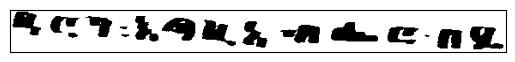

In [9]:
import matplotlib.pyplot as plt 
plt.imshow(x_test_rand[1400], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.gca().spines['left'].set_visible(True)  # Show left border line
plt.gca().spines['right'].set_visible(True)  # Hide right border line
plt.gca().spines['top'].set_visible(True)  # Hide top border line
plt.gca().spines['bottom'].set_visible(True)  # Show bottom border line
plt.show()

In [10]:
 #dictionary used to decode the numeric predictions to text
dict_eth={1: 'ሀ', 2: 'ሁ', 3: 'ሂ', 4: 'ሃ', 5: 'ሄ', 6: 'ህ', 7: 'ሆ', 8: 'ለ', 9: 'ሉ', 10: 'ሊ', 11: 'ላ', 12: 'ሌ', 13: 'ል', 14: 'ሎ', 15: 'ሏ', 16: 'ሐ', 17: 'ሑ', 18: 'ሒ', 19: 'ሓ', 20: 'ሔ', 21: 'ሕ', 22: 'ሖ', 23: 'መ', 24: 'ሙ', 25: 'ሚ', 26: 'ማ', 27: 'ሜ', 28: 'ም', 29: 'ሞ', 30: 'ሟ', 31: 'ሠ', 32: 'ሡ', 33: 'ሢ', 34: 'ሣ', 35: 'ሤ', 36: 'ሥ', 37: 'ሦ', 38: 'ረ', 39: 'ሩ', 40: 'ሪ', 41: 'ራ', 42: 'ሬ', 43: 'ር', 44: 'ሮ', 45: 'ሯ', 46: 'ሰ', 47: 'ሱ', 48: 'ሲ', 49: 'ሳ', 50: 'ሴ', 51: 'ስ', 52: 'ሶ', 53: 'ሷ', 54: 'ሸ', 55: 'ሹ', 56: 'ሺ', 57: 'ሻ', 58: 'ሼ', 59: 'ሽ', 60: 'ሾ', 61: 'ሿ', 62: 'ቀ', 63: 'ቁ', 64: 'ቂ', 65: 'ቃ', 66: 'ቄ', 67: 'ቅ', 68: 'ቆ', 69: 'ቈ', 70: 'ቊ', 71: 'ቋ', 72: 'ቍ', 73: 'በ', 74: 'ቡ', 75: 'ቢ', 76: 'ባ', 77: 'ቤ', 78: 'ብ', 79: 'ቦ', 80: 'ቧ', 81: 'ቨ', 82: 'ቩ', 83: 'ቪ', 84: 'ቫ', 85: 'ቬ', 86: 'ቭ', 87: 'ቮ', 88: 'ተ', 89: 'ቱ', 90: 'ቲ', 91: 'ታ', 92: 'ቴ', 93: 'ት', 94: 'ቶ', 95: 'ቷ', 96: 'ቸ', 97: 'ቹ', 98: 'ቺ', 99: 'ቻ', 100: 'ቼ', 101: 'ች', 102: 'ቾ', 103: 'ቿ', 104: 'ኀ', 105: 'ኁ', 106: 'ኂ', 107: 'ኃ', 108: 'ኄ', 109: 'ኅ', 110: 'ኆ', 111: 'ኈ', 112: 'ኊ', 113: 'ኋ', 114: 'ኍ', 115: 'ነ', 116: 'ኑ', 117: 'ኒ', 118: 'ና', 119: 'ኔ', 120: 'ን', 121: 'ኖ', 122: 'ኗ', 123: 'ኘ', 124: 'ኙ', 125: 'ኚ', 126: 'ኛ', 127: 'ኜ', 128: 'ኝ', 129: 'ኞ', 130: 'ኟ', 131: 'አ', 132: 'ኡ', 133: 'ኢ', 134: 'ኣ', 135: 'ኤ', 136: 'እ', 137: 'ኦ', 138: 'ኧ', 139: 'ከ', 140: 'ኩ', 141: 'ኪ', 142: 'ካ', 143: 'ኬ', 144: 'ክ', 145: 'ኮ', 146: 'ኰ', 147: 'ኲ', 148: 'ኳ', 149: 'ኴ', 150: 'ኵ', 151: 'ኸ', 152: 'ኹ', 153: 'ኺ', 154: 'ኻ', 155: 'ኼ', 156: 'ኽ', 157: 'ኾ', 158: 'ወ', 159: 'ዉ', 160: 'ዊ', 161: 'ዋ', 162: 'ዌ', 163: 'ው', 164: 'ዎ', 165: 'ዏ', 166: 'ዐ', 167: 'ዑ', 168: 'ዒ', 169: 'ዓ', 170: 'ዔ', 171: 'ዕ', 172: 'ዖ', 173: 'ዘ', 174: 'ዙ', 175: 'ዚ', 176: 'ዛ', 177: 'ዜ', 178: 'ዝ', 179: 'ዞ', 180: 'ዟ', 181: 'ዠ', 182: 'ዡ', 183: 'ዢ', 184: 'ዣ', 185: 'ዤ', 186: 'ዥ', 187: 'ዦ', 188: 'የ', 189: 'ዩ', 190: 'ዪ', 191: 'ያ', 192: 'ዬ', 193: 'ይ', 194: 'ዮ', 195: 'ደ', 196: 'ዱ', 197: 'ዲ', 198: 'ዳ', 199: 'ዴ', 200: 'ድ', 201: 'ዶ', 202: 'ዷ', 203: 'ዿ', 204: 'ጀ', 205: 'ጁ', 206: 'ጂ', 207: 'ጃ', 208: 'ጄ', 209: 'ጅ', 210: 'ጆ', 211: 'ጇ', 212: 'ገ', 213: 'ጉ', 214: 'ጊ', 215: 'ጋ', 216: 'ጌ', 217: 'ግ', 218: 'ጎ', 219: 'ጐ', 220: 'ጒ', 221: 'ጓ', 222: 'ጔ', 223: 'ጕ', 224: 'ጠ', 225: 'ጡ', 226: 'ጢ', 227: 'ጣ', 228: 'ጤ', 229: 'ጥ', 230: 'ጦ', 231: 'ጧ', 232: 'ጨ', 233: 'ጩ', 234: 'ጪ', 235: 'ጫ', 236: 'ጬ', 237: 'ጭ', 238: 'ጮ', 239: 'ጯ', 240: 'ጰ', 241: 'ጱ', 242: 'ጲ', 243: 'ጳ', 244: 'ጴ', 245: 'ጵ', 246: 'ጶ', 247: 'ጸ', 248: 'ጹ', 249: 'ጺ', 250: 'ጻ', 251: 'ጼ', 252: 'ጽ', 253: 'ጾ', 254: 'ጿ', 255: 'ፀ', 256: 'ፁ', 257: 'ፂ', 258: 'ፃ', 259: 'ፄ', 260: 'ፅ', 261: 'ፆ', 262: 'ፈ', 263: 'ፉ', 264: 'ፊ', 265: 'ፋ', 266: 'ፌ', 267: 'ፍ', 268: 'ፎ', 269: 'ፏ', 270: 'ፐ', 271: 'ፑ', 272: 'ፒ', 273: 'ፓ', 274: 'ፔ', 275: 'ፕ', 276: 'ፖ', 277: 'ፚ', 278: '፠', 279: '፡', 280: '።', 281: '፣', 282: '፤', 283: '፥', 284: '፦', 285: '፨', 286: '፩', 287: '፪', 288: '፫', 289: '፬', 290: '፭', 291: '፮', 292: '፯', 293: '፰', 294: '፱', 295: '፲', 296: '፳', 297: '፴', 298: '፵', 299: '፶', 300: '፷', 301: '፸', 302: '፹', 303: '፺', 304: '፻', 305: '፼', 306: ' '}

In [ ]:
k=[]
for i,j in dict_eth.items():
  k.append(j)
print(k)

### Load the pretrained Model:
 After downloading the test data and preporfces it, load the one of the pretrained Ethiopic OCR model from github repository as follows.

In [ ]:
%pip install wget
import wget
import tensorflow as tf

m_url = "https://github.com/bdu-birhanu/HHD-Ethiopic/raw/main/hhd-ethiopic/model_belened_CTC_deephyper_0.hdf5"
m_path = "model_belened_CTC_deephyper_0.hdf5"
# Download the model file
wget.download(m_url, m_path)

model = tf.keras.models.load_model(m_path, custom_objects={'Functional': tf.keras.models.Model})

model.summary()
# model= tf.keras.models.load_model(
#     '/content/drive/MyDrive/Code_2023/model/model_belened_CTC_deephyper_0.hdf5',
#     custom_objects={'Functional':tf.keras.models.Model})

# model.summary()

### Visualize the Results
 Use the loaded model and test data to generate predictions.

In [14]:
y_pred=model.predict(x_test_rand_resized)

200/200 [==============================] - 19s 17ms/step


### CTC Decoder

employing the CTC decoder to generate the actual text  using the probablities collcted from the model prediction

In [15]:
y_decode = K.get_value(K.ctc_decode(y_pred[:, :, :], input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1])[0][0])


### Compute Character Error Rate(CER)
 Calculate the CER to evaluate the accuracy of the model's predictions using editdistance.


In [17]:
true = []  # to stor value of character by removing zero which was padded previously and also this is the value of newline in the test label
for i in range(len(y_test_rand)):
    x = [j for j in y_test_rand[i] if j != 0]
    true.append(x)


pred=[]
# to stor the predicted charcter except zerro and -1 which are padded value nad blank space predicted during testing
for i in range(len(y_decode)):
    x=[j for j in y_decode[i] if j not in(0,-1)]
    pred.append(x)

cer=0
for(i,j) in zip(true,pred):
    x=editdistance.eval(i,j)
    cer=cer+x
err=cer
x=0
for i in range(len(true)):
    x=x+len(true[i])
totalchar=x
cerp=(float(err)/totalchar)*100
print("The CER of random test set:", cerp)


The CER of random test set: 16.396747605257296


###  Visualize the Image Ground-Truth and Predictions

To gain insights into the model's performance, it's essential to visualize the image, the ground-truth and corresponding predictions.  See th below resUlts which we provide following these steps.

1. **Load the Image and Ground-Truth Data**: Loading the image data and the corresponding ground-truth labels as sescribed above. 
2. **Generate Predictions**: Use the trained model to generate predictions for the loaded image data. 

3. **Visualize the Image, Ground-Truth and Predictions**:  ground-truth on the left prediction on the right and the images are at the bottom respectivly.

Ground-truth Texts             Prediction Texts
ዕል፡ቀዳማ፡ዘውእቱ፡ሕፁፃ                ዕል፡ቀዳማ፡ዘውእቱ፡ሕፁፃ
ሰከ፡ኅበ፡ይብል፡ሐዲከ፡ዐሉይ፡             ስከ፡ኅበ፡ይብል፡ሐደስ፡ወሉይ፡
ር፡ከመ፡ይምሐረኒ                     ር፡ከመ፡ይምሐረኒ
ናሁ፡አነሥእ፡እዲየ፡መን                 ናሁ፡አነሥእ፡ኔዲየ፡መን
አሚረ፡እሙንቱ፡እለ፡የ                  አሚረ፡እሙንቱ፡እለ፡


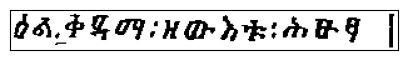

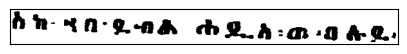

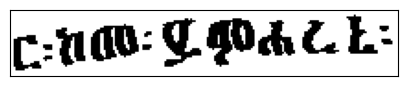

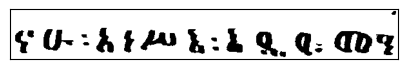

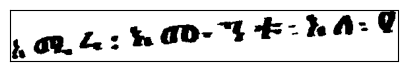

In [18]:
k=1005
b=1010


char_list_true= [[dict_eth[i] for i in text] for text in true]

text_list_true = [''.join(row) for row in char_list_true]

char_list_pred = [[dict_eth[i] for i in text] for text in pred]

text_list_pred = [''.join(row) for row in char_list_pred]

print(f'{"Ground-truth Texts":<30} Prediction Texts')
for i, j in zip(text_list_true[k:b], text_list_pred[k:b]):

    print(f'{("".join(i)):<30} {("".join(j))}')
# Print the text
# print('\n'.join(text_list[:5]))

for i in range(k,b):
    fig = plt.figure(figsize=(5, 2))
    plt.imshow(x_test_rand[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines['left'].set_visible(True)  # Show left border line
    plt.gca().spines['right'].set_visible(True)  # Hide right border line
    plt.gca().spines['top'].set_visible(True)  # Hide top border line
    plt.gca().spines['bottom'].set_visible(True)  # Show bottom border line
    #plt.axis('off')
    plt.show()

Sample example to comput the editdistance between the ground-truth and prediction texts and then compute the CER

In [21]:
import editdistance
x=editdistance.eval('ዓገሠ።በዝሕማም፡መሥጋ፡ ','ዓገሠ።በዝሕማም፡በሥጋ፡')

print("gt vs model "+ str(x))


gt vs model 2


In [22]:
gt='ዓገሠ።በዝሕማም፡መሥጋ፡'
CER=float((x))/len(gt)*100
print(CER)

14.285714285714285
